In [72]:
# 1) 📦 IMPORT LIBRARIES AND SET UP DATABASE CONNECTION

# Used for loading environment variables (.env file)
import os
from dotenv import load_dotenv

# Data handling and manipulation
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SQLAlchemy for PostgreSQL connections
from sqlalchemy import create_engine

# Load environment variables like DB credentials
load_dotenv()

# Initialize database engine using credentials from .env
engine = create_engine(
    f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASS')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
)

In [73]:
# Check what status values actually exist
status_check = pd.read_sql(
    sql="""
    SELECT LOWER("status") AS status, COUNT(*) AS count
    FROM "customer_crm"
    WHERE "status" IS NOT NULL
    GROUP BY 1
    ORDER BY count DESC;
    """,
    con=engine
)

status_check

,status,count
0,at risk,194
1,active,180
2,churned,126


In [74]:
# 2) 📥 LOAD QUARTERLY ENGAGEMENT + PERFORMANCE DATA FROM SQL

from sqlalchemy import text  # make sure this import is present

# Read SQL from file
with open("../queries/quarterly_engagement_vs_arr.sql") as f:
    raw_sql = f.read()

# Use SQLAlchemy's text() to make the query compatible with DBAPI
with engine.connect() as conn:
    df = pd.read_sql_query(sql=text(raw_sql), con=conn)

# Preview data
print(df.shape)
print(df.columns)
df.head(20)

(8730, 4)
Index(['quarter', 'avg_arr', 'retention_rate', 'avg_engagement_score'], dtype='object')


,quarter,avg_arr,retention_rate,avg_engagement_score
0,2023-01-01,106216.463333,0.666667,4.067500
1,2023-01-01,106216.463333,0.666667,3.971111
2,2023-01-01,106216.463333,0.666667,3.851667
3,2023-01-01,106216.463333,0.666667,4.070000
4,2023-01-01,106216.463333,0.666667,4.015000
5,2023-01-01,106216.463333,0.666667,3.908333
6,2023-01-01,106216.463333,0.666667,4.068571
7,2023-01-01,106216.463333,0.666667,3.971000
8,2023-01-01,106216.463333,0.666667,4.073000
9,2023-01-01,106216.463333,0.666667,4.001111


In [ ]:
# 3) 🧹 FORMAT DATE AND DROP INCOMPLETE ROWS

# Convert 'quarter' column to datetime (ensures correct handling in plots and filters)
df["quarter"] = pd.to_datetime(df["quarter"])

# Drop rows with missing values in key metrics — helps ensure clean visualizations
df = df.dropna(subset=["avg_engagement_score", "retention_rate"])

# Display descriptive statistics to sanity check value ranges
df.describe()

KeyError: ['win_rate']

In [ ]:
df.shape

(8730, 4)

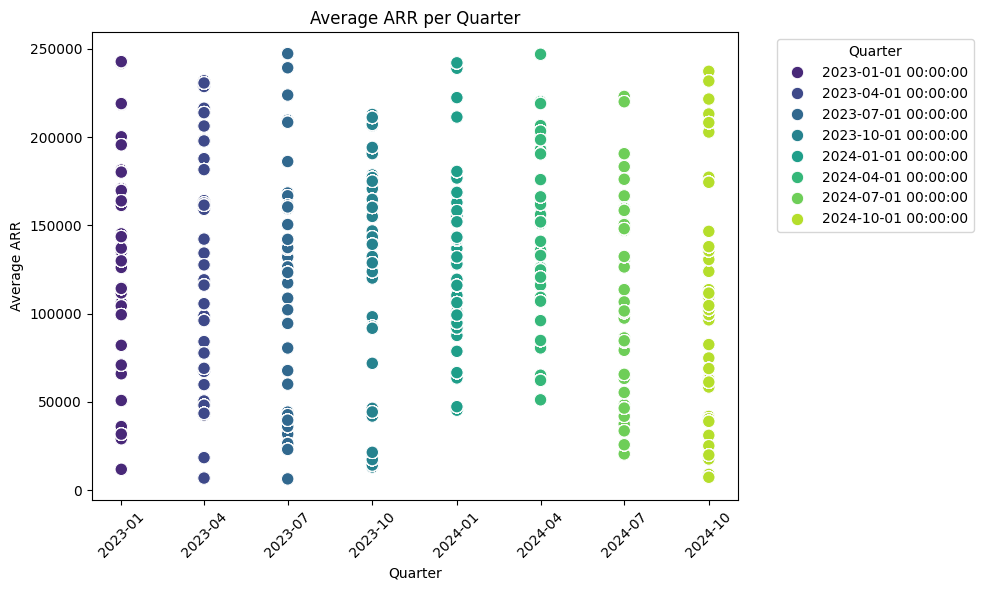

In [ ]:
# 4) 📊 AVERAGE ARR PER QUARTER

plt.figure(figsize=(10, 6))

# Scatterplot of average ARR, one point per row (likely grouped by quarter already)
sns.scatterplot(
    data=df,
    x="quarter",
    y="avg_arr",
    hue="quarter",          # Optional: color by time
    palette="viridis",
    s=80
)

plt.title("Average ARR per Quarter")
plt.xlabel("Quarter")
plt.ylabel("Average ARR")
plt.xticks(rotation=45)
plt.legend(title="Quarter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Check that values actually exist for plotting
print(df[["avg_engagement_score", "win_rate"]].isnull().sum())
print(df[["avg_engagement_score", "win_rate"]].describe())
df[["avg_engagement_score", "win_rate", "quarter"]].head(10)

avg_engagement_score    0
win_rate                0
dtype: int64
       avg_engagement_score  win_rate
count           8730.000000    8730.0
mean               3.977736       0.0
std                0.061487       0.0
min                3.796000       0.0
25%                3.942500       0.0
50%                3.975000       0.0
75%                4.012500       0.0
max                4.225000       0.0


,avg_engagement_score,win_rate,quarter
0,4.067500,0.0,2023-01-01
1,3.971111,0.0,2023-01-01
2,3.851667,0.0,2023-01-01
3,4.070000,0.0,2023-01-01
4,4.015000,0.0,2023-01-01
5,3.908333,0.0,2023-01-01
6,4.068571,0.0,2023-01-01
7,3.971000,0.0,2023-01-01
8,4.073000,0.0,2023-01-01
9,4.001111,0.0,2023-01-01


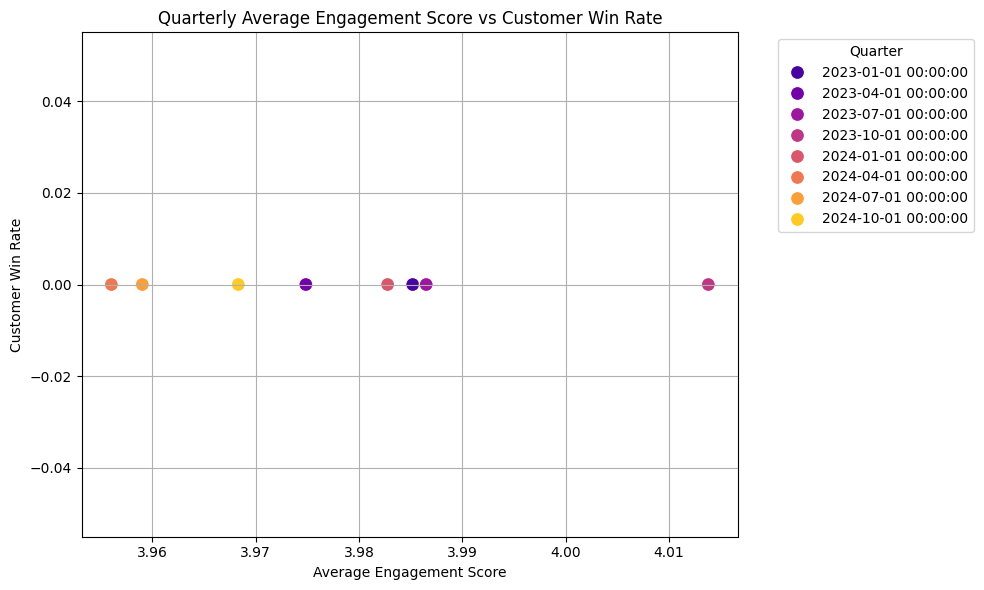

In [ ]:
# 5) 📊 ENGAGEMENT SCORE VS WIN RATE — QUARTERLY AVERAGED VIEW

# Group data by quarter and calculate average engagement and win rate
quarterly_avg = df.groupby("quarter").agg({
    "avg_engagement_score": "mean",
    "retention_rate": "mean"
}).reset_index()

# Plot average engagement score vs average win rate by quarter
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=quarterly_avg,
    x="avg_engagement_score",
    y="win_rate",
    hue="quarter",              # Color by quarter to distinguish time
    palette="plasma",
    s=100                       # Slightly larger point size
)

plt.title("Quarterly Average Engagement Score vs Customer Win Rate")
plt.xlabel("Average Engagement Score")
plt.ylabel("Customer Win Rate")
plt.legend(title="Quarter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()